In [1]:
import numpy as np
import random as rn
rn.seed(0)
import numpy.random as npr
npr.seed(0)
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc

%load_ext autoreload 
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
TISSUE = 'testis'
VERSION = 'final'
SAVEFIGS = True

In [3]:
cell_mapping = {
    'early primary spermatocytes':'Preleptotene spermatocytes',
    'elongated spermatids':'Elongated/late spermatids',
    'endothelial cells':None,
    'late primary spermatocytes':'Pachytene spermatocytes',
    'leydig cells':'Leydig cells',
    'macrophages':None,
    'myoid cells':'Peritubular cells',
    'round spermatids':'Round/early spermatids',
    'sertoli cells':'Sertoli cells',
    'sperm cells':None,
    'spermatogonial stem cells':'Spermatogonia'
}

In [4]:
dhc_df = pd.read_excel('mmc1.xlsx',skiprows=2,index_col=0)
dhc_df['Image'] = dhc_df['Image_URL'].map(lambda s: s.split('/')[-1].replace('.jpg',''))
dhc_df = dhc_df.reset_index().set_index('Image')
dhc_df['is_marker'] = dhc_df.filter(like='manual annotation').sum(1)==1
true_labels = dhc_df.filter(like='manual annotation')
true_labels.columns = true_labels.columns.map(lambda s: s.split('_')[0])
true_labels

,Spermatogonia,Preleptotene spermatocytes,Pachytene spermatocytes,Round/early spermatids,Elongated/late spermatids,Sertoli cells,Leydig cells,Peritubular cells
Image,,,,,,,,
17921_A_5_6,1,1,0,0,1,1,0,0
17921_A_6_6,1,1,0,0,1,1,0,0
17921_A_4_6,1,1,0,0,1,1,0,0
8261_A_5_6,1,1,1,0,0,0,0,0
8261_A_6_6,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
145587_A_6_6,0,0,0,1,1,0,1,0
145587_A_4_6,0,0,0,1,1,0,1,0
140656_A_5_6,0,0,0,0,1,0,0,0


In [5]:
simclr_labels = pd.read_csv(f'./data/{TISSUE}_{VERSION}_scores.csv',index_col=0)
simclr_labels = simclr_labels[[k for k,v in cell_mapping.items() if v is not None]]
simclr_labels.values[:] = simclr_labels.values / simclr_labels.values.sum(1,keepdims=True)
simclr_labels.columns = simclr_labels.columns.map(cell_mapping)
# some present in both HPAv21 and the Ghoshal et al set; drop these to ensure no contamination
simclr_labels = simclr_labels.reset_index().drop_duplicates(subset='index',keep=False).set_index('index')
simclr_labels = simclr_labels.loc[simclr_labels.index.isin(set(true_labels.index))]
simclr_labels

,Preleptotene spermatocytes,Elongated/late spermatids,Pachytene spermatocytes,Leydig cells,Peritubular cells,Round/early spermatids,Sertoli cells,Spermatogonia
index,,,,,,,,
32595_A_4_6,0.130661,0.132279,0.116227,0.107083,0.131173,0.093710,0.153036,0.135830
32595_A_6_6,0.089576,0.266498,0.126097,0.057620,0.099249,0.149355,0.082809,0.128796
32595_A_5_6,0.172158,0.095216,0.130503,0.090940,0.105683,0.076516,0.136805,0.192180
147454_A_6_6,0.285018,0.076030,0.286101,0.025370,0.023988,0.114188,0.040824,0.148481
147454_A_5_6,0.258396,0.079658,0.226559,0.032972,0.032965,0.121107,0.070874,0.177470
...,...,...,...,...,...,...,...,...
24682_A_4_6,0.298260,0.077051,0.142260,0.058764,0.042265,0.087216,0.081378,0.212806
24682_A_6_6,0.258049,0.105271,0.122349,0.071663,0.050497,0.093431,0.095121,0.203619
24224_A_6_6,0.182121,0.105048,0.137203,0.075027,0.072806,0.092689,0.130168,0.204938


In [6]:
dhc_labels = dhc_df.filter(like='Predict_Proba')
dhc_labels.columns = dhc_labels.columns.map(lambda s: s.split('_')[0])
dhc_labels

,Spermatogonia,Preleptotene spermatocytes,Pachytene spermatocytes,Round/early spermatids,Elongated/late spermatids,Sertoli cells,Leydig cells,Peritubular cells
Image,,,,,,,,
17921_A_5_6,1.000000e+00,1.000000e+00,0.000639,0.044028,1.000000,9.991020e-01,1.460000e-06,1.720000e-06
17921_A_6_6,9.999998e-01,1.000000e+00,0.680156,0.427155,1.000000,9.552041e-01,1.520000e-07,4.770000e-10
17921_A_4_6,9.999996e-01,1.000000e+00,0.222564,0.201533,1.000000,9.937708e-01,3.710000e-05,1.740000e-05
8261_A_5_6,1.000000e+00,1.000000e+00,1.000000,0.374006,0.057148,2.980000e-11,6.200000e-07,1.600000e-05
8261_A_6_6,9.999985e-01,1.000000e+00,1.000000,0.717444,0.030742,2.540000e-08,1.280000e-07,3.220000e-06
...,...,...,...,...,...,...,...,...
145587_A_6_6,7.580000e-06,2.579160e-04,0.029378,1.000000,1.000000,0.000000e+00,1.000000e+00,1.240000e-06
145587_A_4_6,2.700000e-06,2.410000e-05,0.032954,1.000000,1.000000,0.000000e+00,9.999999e-01,1.330000e-06
140656_A_5_6,1.450000e-07,4.700000e-05,0.000005,0.362057,1.000000,0.000000e+00,9.720000e-08,9.420000e-09


In [7]:
adata = sc.read('./data/testis.h5')

sc.tl.rank_genes_groups(adata,groupby='cell_type',method='wilcoxon',use_raw=False)
wilcoxon_scores = sc.get.rank_genes_groups_df(adata,group=None)
wilcoxon_scores = wilcoxon_scores.pivot(index='names',columns='group',values='scores')

sc.tl.rank_genes_groups(adata,groupby='cell_type',method='t-test',use_raw=False)
ttest_scores = sc.get.rank_genes_groups_df(adata,group=None)
ttest_scores = ttest_scores.pivot(index='names',columns='group',values='scores')

wilcoxon_labels = wilcoxon_scores[[k for k,v in cell_mapping.items() if v is not None]]
wilcoxon_labels.columns = wilcoxon_labels.columns.map(cell_mapping)

ttest_labels = ttest_scores[[k for k,v in cell_mapping.items() if v is not None]]
ttest_labels.columns = ttest_labels.columns.map(cell_mapping)

adata

AnnData object with n_obs × n_vars = 6490 × 18361
    obs: 'Donor', 'leiden', 'cell_type'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Donor_colors', 'cell_type_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'umap', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Aggregate to gene level so we can compare to scRNA.

In [8]:
simclr_labels = simclr_labels.join(dhc_df['ENSG_ID']).groupby('ENSG_ID').mean()
true_labels = true_labels.join(dhc_df['ENSG_ID']).groupby('ENSG_ID').median().astype(int)
dhc_labels = dhc_labels.join(dhc_df['ENSG_ID']).groupby('ENSG_ID').mean()

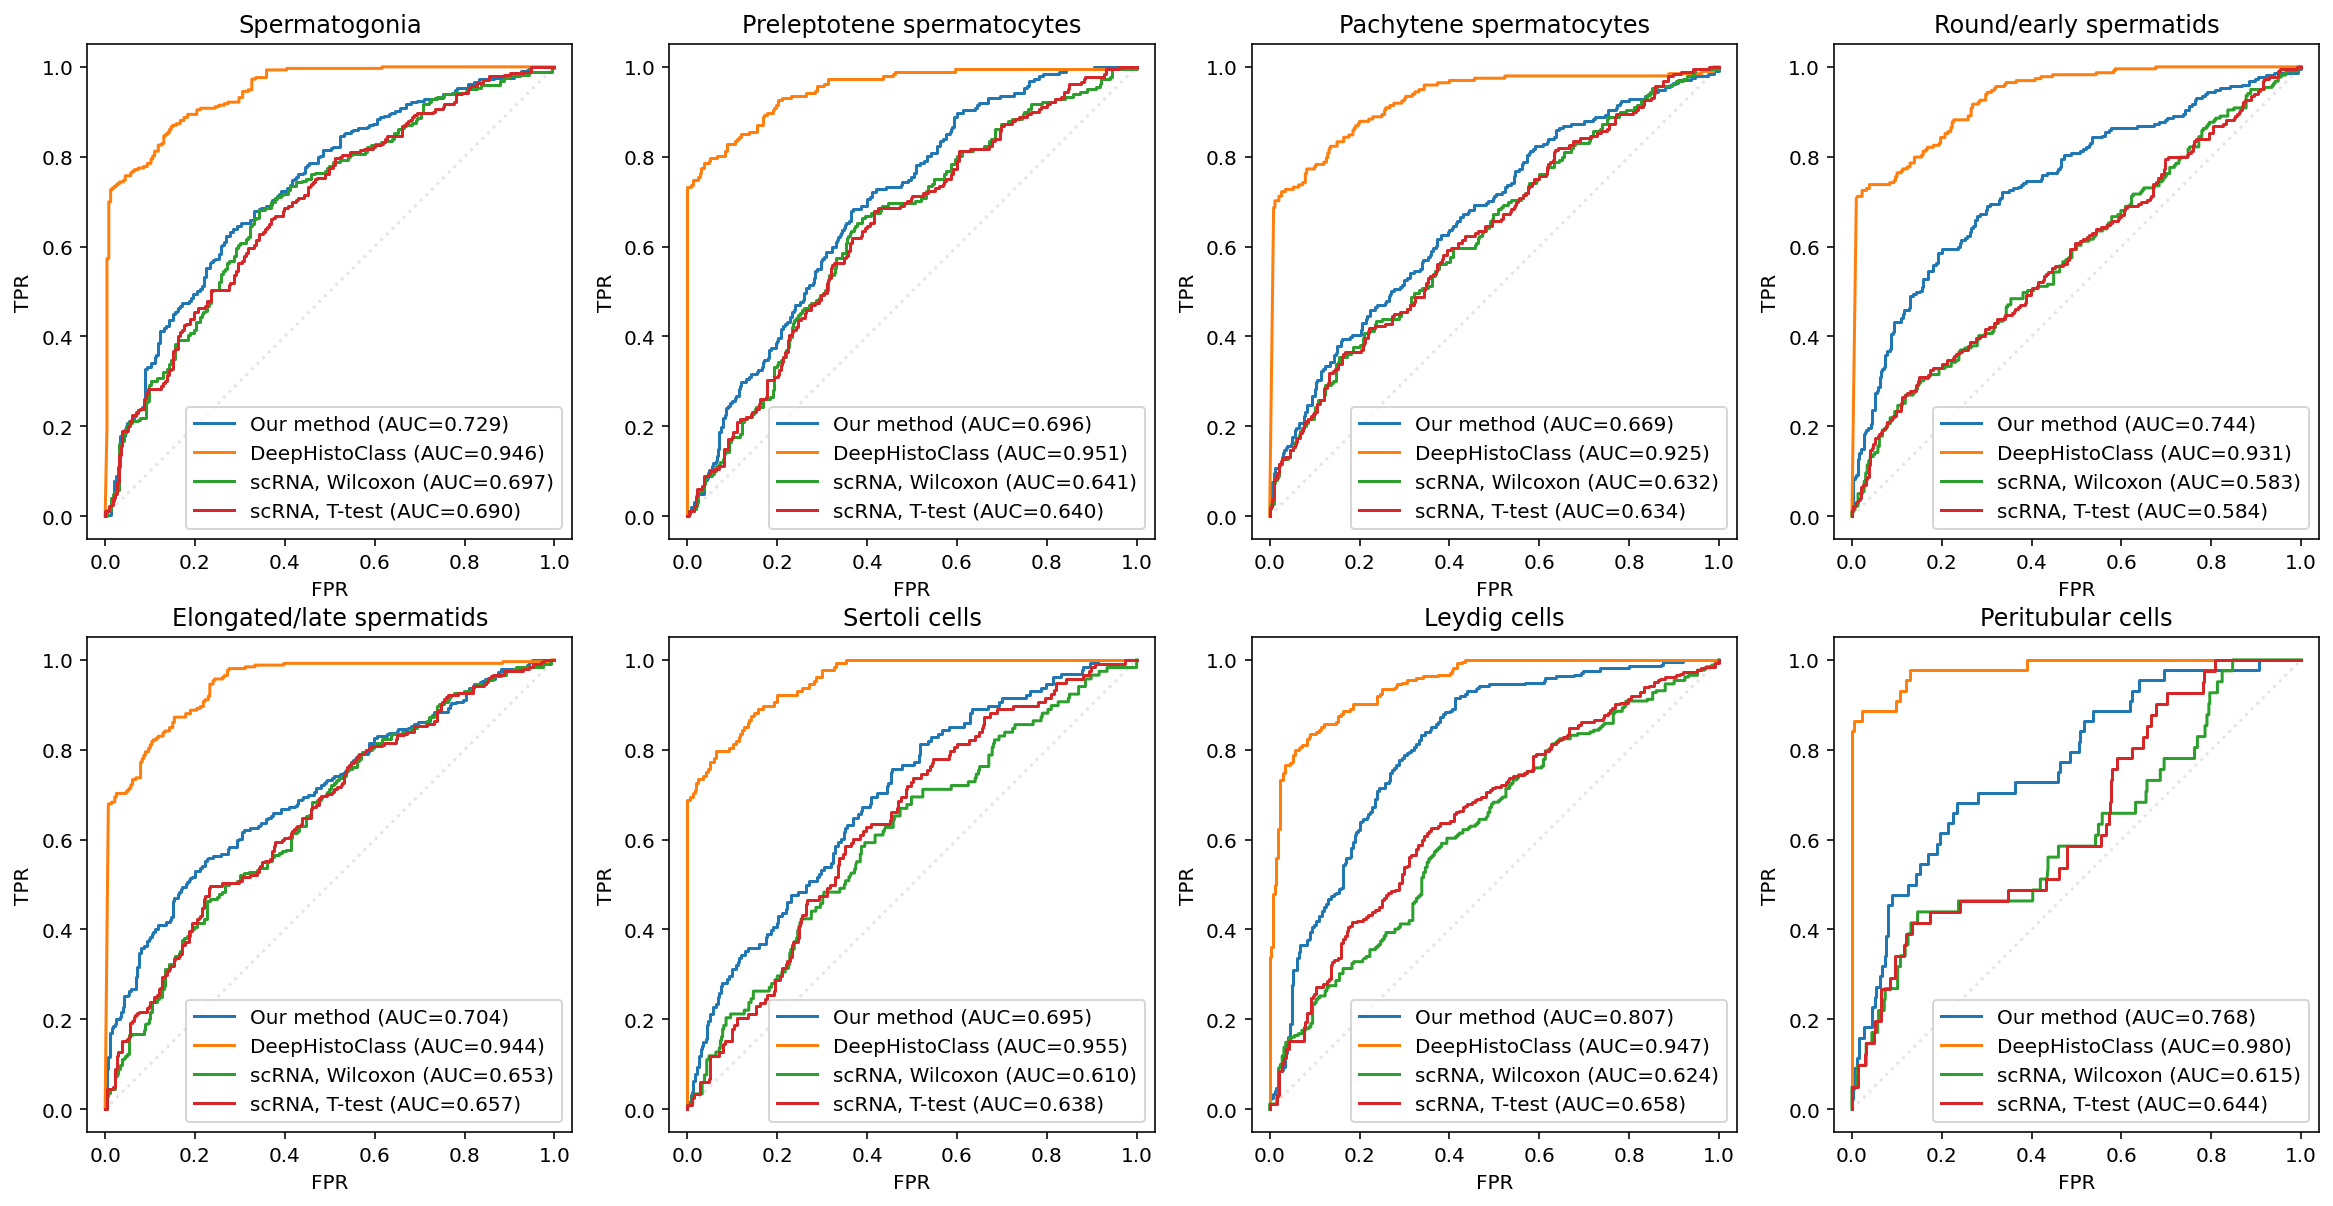

In [9]:
from sklearn.metrics import roc_curve, roc_auc_score

regions = true_labels.columns

def plot_roc(region_scores, ax, name, **kwargs):
#     try:
    y = true_labels[region]
    y_pred = region_scores[region]
    idx = list(set(y.index)&set(y_pred.index))
    y, y_pred = y[idx], y_pred[idx]
    fpr, tpr, thr = roc_curve(y,y_pred)
    auc = roc_auc_score(y,y_pred)
    ax.plot(fpr,tpr,label=f'{name} (AUC=%.3f)'%auc, **kwargs)
#     except:
#         pass

figsize = 5
fig,axs = plt.subplots(2,len(regions)//2,figsize=(len(regions)//2*figsize,2*figsize))
axs=axs.ravel()
for ax,region in zip(axs,regions):
    ax.plot([0,1],[0,1],'k:',alpha=0.1)
    ax.set_title(region)

    plot_roc(simclr_labels, ax, 'Our method')
    plot_roc(dhc_labels, ax, 'DeepHistoClass')
    plot_roc(wilcoxon_labels, ax, 'scRNA, Wilcoxon')
    plot_roc(ttest_labels, ax, 'scRNA, T-test')
    
    ax.axis('equal')
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.legend()

if SAVEFIGS:
    plt.savefig(f'./figures/{TISSUE}_{VERSION}_roc.png', dpi=300);
else:
    plt.show()

While we outperform the scRNA in most cases, DHC in turn outperforms our approach substantially. Possible reasons for this:

- DHC is a supervised learning algorithm and uses image labels provided by human annotators.

- DHC uses full 3000x3000 images, while we downsampled to 512x512. In kidney, cell identity correlates substantially with macroscopic tissue structure, which downsampling preserves. Cells in the testis of different types intermix more in space by comparison (e.g. spermatids at different developmental stages) and therefore likely require finer-scale information to resolve. The fact our best-performing class (peritubular cells, AUC = 0.798) displays particular spatial organization supports this hypothesis.

- As the cluster assignments in https://www.nature.com/articles/s41422-018-0099-2 were not published, we had to manually cluster and annotate these data ourselves according to the expression of marker genes described in that paper; as we are not experts in this tissue, it is possible incorrect assignments were made.